In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
jeju = pd.read_excel('/content/drive/MyDrive/Daily Jeju tourist arrival (2022.06.01-2024.03.31).xlsx')

In [4]:
jeju

,Date,Korean Arrival,Foreign Arrival,Total Arrival
0,2022-06-01,46508,152,46660
1,2022-06-02,42635,167,42802
2,2022-06-03,45180,332,45512
3,2022-06-04,49251,123,49374
4,2022-06-05,39927,174,40101
...,...,...,...,...
665,2024-03-27,32834,9438,42272
666,2024-03-28,33266,3336,36602
667,2024-03-29,35414,3761,39175
668,2024-03-30,35139,10783,45922


In [ ]:
# 총 방문객 수 Series로 변경
jeju['날짜'] = pd.to_datetime(jeju['날짜'])
jeju.set_index('날짜', inplace=True)
jeju_series = pd.Series(jeju['총합'])

In [ ]:
jeju_series

날짜
2022-06-01    46660
2022-06-02    42802
2022-06-03    45512
2022-06-04    49374
2022-06-05    40101
              ...  
2024-03-27    42272
2024-03-28    36602
2024-03-29    39175
2024-03-30    45922
2024-03-31    41294
Name: 총합, Length: 670, dtype: int64

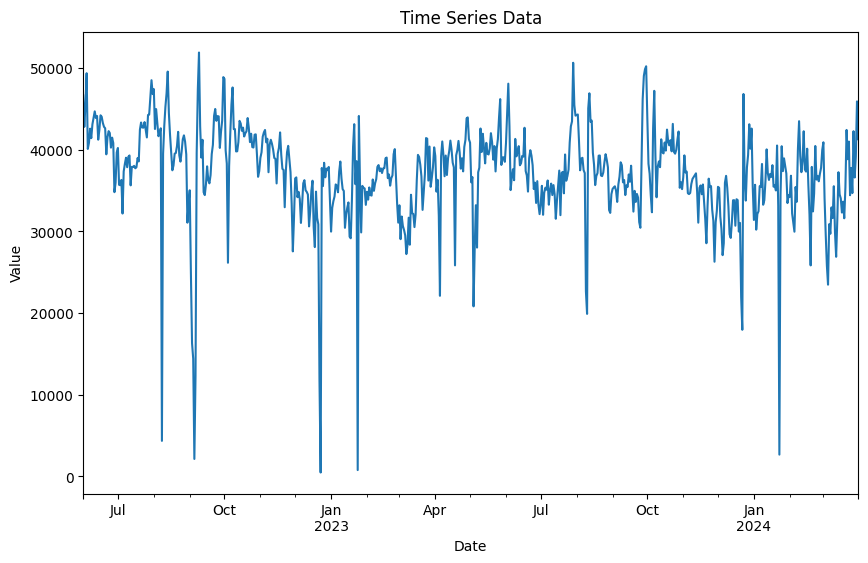

In [ ]:
jeju_series.plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse

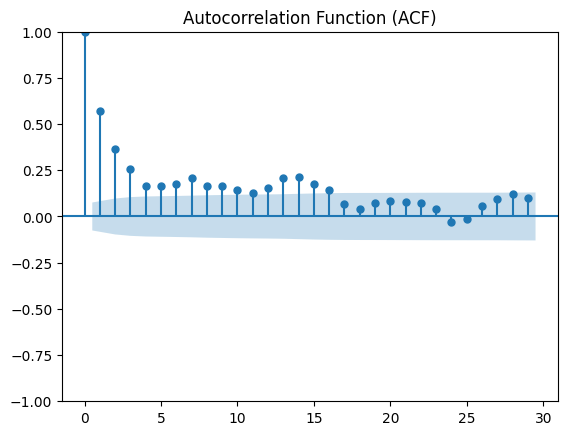

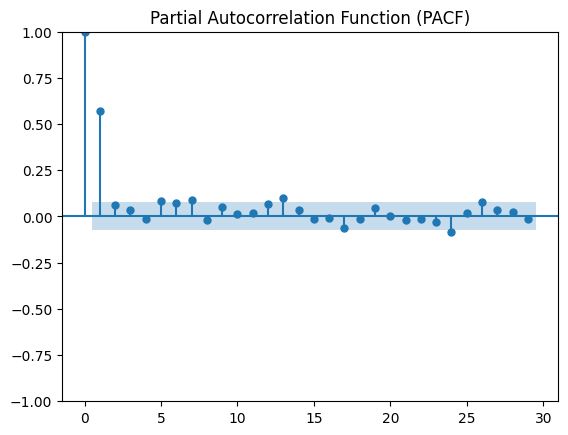

In [ ]:
# Plot ACF and PACF to determine the order of SARIMA parameters
plot_acf(jeju_series)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(jeju_series)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
# ADF 테스트를 진행해서 차분이 필요한지 결정.

from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST 결과')
adf_test(jeju_series)

ADF TEST 결과
ADF Statistics: -4.471118
p-value: 0.000222
num of lags: 12.000000
num of observations: 657.000000
Critical values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


p-value가 0.05이므로 기각. 즉 차분이 필요없음.

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

#SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


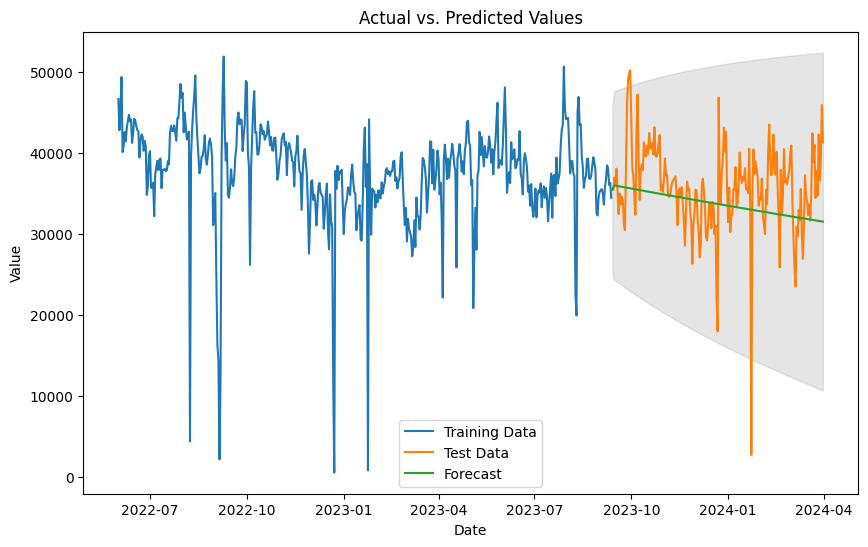

RMSE: 5548.047153808929


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse


# Split the data into training and testing sets
train_data, test_data = train_test_split(jeju_series, test_size = 0.3, shuffle = False)

# Define SARIMA model parameters
order = (1, 0, 3)  # ARIMA order
seasonal_order = (0, 0, 0, 30)  # SARIMA seasonal order

# Fit the SARIMA model
sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
sarima_results = sarima_model.fit()

# Forecast
forecast = sarima_results.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, forecast_mean, label='Forecast')
plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Evaluate the model
print("RMSE:", rmse(test_data, forecast_mean))

In [ ]:
sarima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     총합   No. Observations:                  469
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -4617.078
Date:                Fri, 12 Apr 2024   AIC                           9244.156
Time:                        11:59:05   BIC                           9264.866
Sample:                    06-01-2022   HQIC                          9252.308
                         - 09-12-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.001   1019.987      0.000       0.997       1.001
ma.L1         -0.4897      0.020    -24.554      0.000      -0.529      -0.451
ma.L2         -0.1971      0.035     -5.665      0.000      -0.265      -0.129
ma.L3         -0.1807      0.037     -4.936      0.000      -0.252      -0.109
sigma2      2.602e+07   6.12e-10   4.25e+16      0.000     2.6e+07     2.6e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):              6351.28
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -1.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+32. Standard errors may be unstable.
"""

#1.SARIAM-CNN-LSTM

In [ ]:
# Calculate the difference between actual and predicted values
difference = test_data - forecast_mean

# Create a DataFrame with the actual, predicted, and difference values
result_df = pd.DataFrame({'Actual': test_data, 'Predicted': forecast_mean, 'Difference': difference})

# Print the DataFrame
print(result_df)

            Actual     Predicted    Difference
2023-09-13   35648  35419.259065    228.740935
2023-09-14   35452  35683.979348   -231.979348
2023-09-15   36975  35973.361171   1001.638829
2023-09-16   36082  35949.290116    132.709884
2023-09-17   38047  35925.235168   2121.764832
...            ...           ...           ...
2024-03-27   42272  31592.601051  10679.398949
2024-03-28   36602  31571.461318   5030.538682
2024-03-29   39175  31550.335731   7624.664269
2024-03-30   45922  31529.224280  14392.775720
2024-03-31   41294  31508.126955   9785.873045

[201 rows x 3 columns]


In [ ]:
# 시계열 데이터 처리가 가능하도록 형태 변경 함수
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
X1 = result_df['Difference']

In [ ]:
# 이전 14일의 데이터를 통해 다음날을 예측
if isinstance(X1, pd.Series):
    X1 = pd.DataFrame(X1)

window = 13
lag = 1
series = series_to_supervised(X1, window=window, lag=lag)
series

,Difference(t-13),Difference(t-12),Difference(t-11),Difference(t-10),Difference(t-9),Difference(t-8),Difference(t-7),Difference(t-6),Difference(t-5),Difference(t-4),Difference(t-3),Difference(t-2),Difference(t-1),Difference(t),Difference(t+1)
2023-09-26,228.740935,-231.979348,1001.638829,132.709884,2121.764832,-700.196316,-3451.173549,-885.166857,-2218.176228,-1213.201653,-1636.243119,-4611.300617,-5287.374136,2964.536335,10506.430807
2023-09-27,-231.979348,1001.638829,132.709884,2121.764832,-700.196316,-3451.173549,-885.166857,-2218.176228,-1213.201653,-1636.243119,-4611.300617,-5287.374136,2964.536335,10506.430807,13378.309290
2023-09-28,1001.638829,132.709884,2121.764832,-700.196316,-3451.173549,-885.166857,-2218.176228,-1213.201653,-1636.243119,-4611.300617,-5287.374136,2964.536335,10506.430807,13378.309290,14228.171795
2023-09-29,132.709884,2121.764832,-700.196316,-3451.173549,-885.166857,-2218.176228,-1213.201653,-1636.243119,-4611.300617,-5287.374136,2964.536335,10506.430807,13378.309290,14228.171795,14610.018333
2023-09-30,2121.764832,-700.196316,-3451.173549,-885.166857,-2218.176228,-1213.201653,-1636.243119,-4611.300617,-5287.374136,2964.536335,10506.430807,13378.309290,14228.171795,14610.018333,8341.848914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26,-488.047884,5380.290880,2693.615367,2214.925584,505.221542,1860.503250,-153.229282,3643.023955,10707.262970,7143.487774,9325.698376,2775.894784,6122.077010,3080.245062,10679.398949
2024-03-27,5380.290880,2693.615367,2214.925584,505.221542,1860.503250,-153.229282,3643.023955,10707.262970,7143.487774,9325.698376,2775.894784,6122.077010,3080.245062,10679.398949,5030.538682
2024-03-28,2693.615367,2214.925584,505.221542,1860.503250,-153.229282,3643.023955,10707.262970,7143.487774,9325.698376,2775.894784,6122.077010,3080.245062,10679.398949,5030.538682,7624.664269
2024-03-29,2214.925584,505.221542,1860.503250,-153.229282,3643.023955,10707.262970,7143.487774,9325.698376,2775.894784,6122.077010,3080.245062,10679.398949,5030.538682,7624.664269,14392.775720


In [ ]:
# Y label
labels_col = 'Difference(t+1)'
labels = series[labels_col]

In [ ]:
series = series.drop('Difference(t+1)', axis=1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(series, labels.values, test_size=0.2, shuffle = False)
print('Train set shape', X_train.shape)
print('Test set shape', X_test.shape)

Train set shape (149, 14)
Test set shape (38, 14)


In [ ]:
from sklearn.preprocessing import StandardScaler

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

# standard scaler를 이용해 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train)
Y_test = scaler.transform(Y_test)

In [ ]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('test set shape', X_test_series.shape)

Train set shape (149, 14, 1)
test set shape (38, 14, 1)


In [ ]:
# CNN-LSTM에 적합하도록 데이터 형태 변경
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('test set shape', X_test_series_sub.shape)

Train set shape (149, 2, 7, 1)
test set shape (38, 2, 7, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from keras import optimizers

In [ ]:
# CNN-LSTM model

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
ely = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, epochs=30, verbose = 2)

Epoch 1/30
5/5 - 5s - loss: 0.9982 - 5s/epoch - 914ms/step
Epoch 2/30
5/5 - 0s - loss: 0.9676 - 35ms/epoch - 7ms/step
Epoch 3/30
5/5 - 0s - loss: 0.9527 - 41ms/epoch - 8ms/step
Epoch 4/30
5/5 - 0s - loss: 0.9397 - 40ms/epoch - 8ms/step
Epoch 5/30
5/5 - 0s - loss: 0.9297 - 38ms/epoch - 8ms/step
Epoch 6/30
5/5 - 0s - loss: 0.9165 - 44ms/epoch - 9ms/step
Epoch 7/30
5/5 - 0s - loss: 0.9056 - 41ms/epoch - 8ms/step
Epoch 8/30
5/5 - 0s - loss: 0.8938 - 33ms/epoch - 7ms/step
Epoch 9/30
5/5 - 0s - loss: 0.8792 - 35ms/epoch - 7ms/step
Epoch 10/30
5/5 - 0s - loss: 0.8654 - 36ms/epoch - 7ms/step
Epoch 11/30
5/5 - 0s - loss: 0.8481 - 76ms/epoch - 15ms/step
Epoch 12/30
5/5 - 0s - loss: 0.8352 - 72ms/epoch - 14ms/step
Epoch 13/30
5/5 - 0s - loss: 0.8200 - 71ms/epoch - 14ms/step
Epoch 14/30
5/5 - 0s - loss: 0.8016 - 68ms/epoch - 14ms/step
Epoch 15/30
5/5 - 0s - loss: 0.7906 - 64ms/epoch - 13ms/step
Epoch 16/30
5/5 - 0s - loss: 0.7739 - 60ms/epoch - 12ms/step
Epoch 17/30
5/5 - 0s - loss: 0.7607 - 60ms/

In [ ]:
# Test data 예측 결과
yhat = model_cnn_lstm.predict(X_test_series_sub)

2/2 [==============================] - 0s 73ms/step


In [ ]:
#model residual
yhat = scaler.inverse_transform(yhat)
df = pd.DataFrame(yhat, columns=['cnn-lstm residual'])

In [ ]:
# 시작일과 종료일 지정
start_date = '2024-02-23'
end_date = '2024-03-31'

# 날짜 범위 생성
date_range = pd.date_range(start=start_date, end=end_date)

# 날짜 범위를 데이터프레임의 인덱스로 설정
df.index = date_range

In [ ]:
result_df_p = result_df[['Predicted']].tail(38)

In [ ]:
# test data 최종 예측 결과값
res = pd.concat([df, result_df_p], axis = 1)
res['predicted_value'] = res['Predicted'] + res['cnn-lstm residual']

In [ ]:
# train data역시 마찬가지로 예측값 구하기
yhat2 = model_cnn_lstm.predict(X_train_series_sub)
yhat2 = scaler.inverse_transform(yhat2)
df2 = pd.DataFrame(yhat2, columns=['cnn-lstm residual'])

# 시작일과 종료일 지정
start_date = '2023-09-27'
end_date = '2024-02-22'

# 날짜 범위 생성
date_range2 = pd.date_range(start=start_date, end=end_date)

# 날짜 범위를 데이터프레임의 인덱스로 설정
df2.index = date_range2

5/5 [==============================] - 0s 3ms/step


In [ ]:
result_df_p2 = result_df[['Predicted']].iloc[14:163]
res2 = pd.concat([df2, result_df_p2], axis = 1)
res2['predicted_value'] = res2['Predicted'] + res2['cnn-lstm residual']

In [ ]:
res3 = pd.concat([res2, res])
res3

,cnn-lstm residual,Predicted,predicted_value
2023-09-27,492.928314,35685.569193,36178.497507
2023-09-28,2025.159424,35661.690710,37686.850134
2023-09-29,9216.021484,35637.828205,44853.849689
2023-09-30,12260.787109,35613.981667,47874.768776
2023-10-01,8220.723633,35590.151086,43810.874718
...,...,...,...
2024-03-27,2915.533936,31592.601051,34508.134987
2024-03-28,3900.483154,31571.461318,35471.944473
2024-03-29,3316.612549,31550.335731,34866.948280
2024-03-30,2002.911743,31529.224280,33532.136023


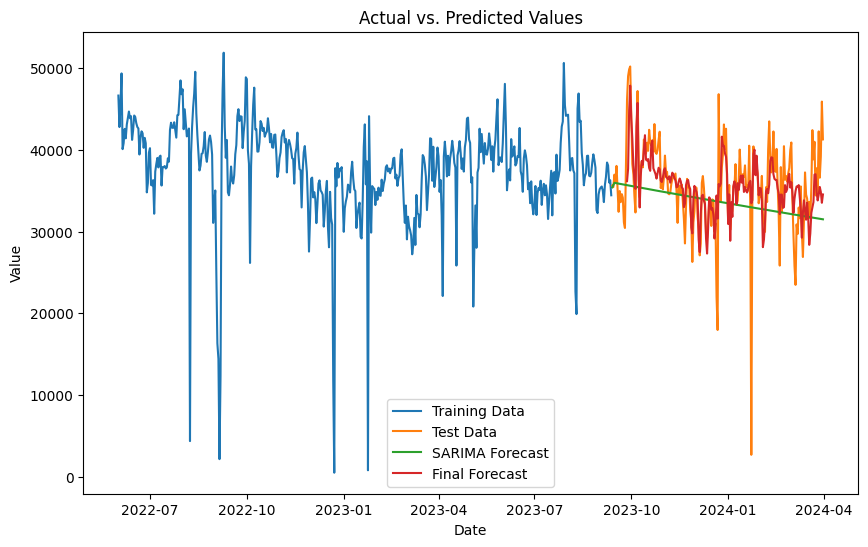

In [ ]:
# Plot actual vs. predicted values / 최종 예측 플롯
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, forecast_mean, label='SARIMA Forecast')
plt.plot(res3.index, res3['predicted_value'], label='Final Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# 최종 RMSE 비교

In [ ]:
print("RMSE:", rmse(jeju['총합'].tail(187), res3['predicted_value']))

RMSE: 4207.5056005730385


In [ ]:
print("RMSE:", rmse(jeju['총합'].tail(187), forecast_mean.tail(187)))

RMSE: 5711.913908104509


단순 SARIMA보다 SARIMA-CNN-LSTM이 훨씬 좋은 성능을 보임

# 2.SARIMA-LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
history = model_lstm.fit(X_train_series, Y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
4/4 [==============================] - 0s 78ms/step - loss: 0.9741 - val_loss: 0.5019
Epoch 2/30
4/4 [==============================] - 0s 49ms/step - loss: 0.9626 - val_loss: 0.5023
Epoch 3/30
4/4 [==============================] - 0s 46ms/step - loss: 0.9475 - val_loss: 0.5011
Epoch 4/30
4/4 [==============================] - 0s 42ms/step - loss: 0.9379 - val_loss: 0.5030
Epoch 5/30
4/4 [==============================] - 0s 42ms/step - loss: 0.9220 - val_loss: 0.5057
Epoch 6/30
4/4 [==============================] - 0s 48ms/step - loss: 0.9083 - val_loss: 0.5092
Epoch 7/30
4/4 [==============================] - 0s 53ms/step - loss: 0.8973 - val_loss: 0.5172
Epoch 8/30
4/4 [==============================] - 0s 51ms/step - loss: 0.8913 - val_loss: 0.5289
Epoch 9/30
4/4 [==============================] - 0s 53ms/step - loss: 0.8793 - val_loss: 0.5103
Epoch 10/30
4/4 [==============================] - 0s 40ms/step - loss: 0.8744 - val_loss: 0.5100
Epoch 11/30
4/4 [============

In [ ]:
yhat_t = model_lstm.predict(X_test_series)
yhat_t = scaler.inverse_transform(yhat_t.reshape(-1, yhat_t.shape[-1]))
dft = pd.DataFrame(yhat_t, columns=['lstm residual'])

# 시작일과 종료일 지정
start_date = '2024-02-23'
end_date = '2024-03-31'

# 날짜 범위 생성
date_range = pd.date_range(start=start_date, end=end_date)

# 날짜 범위를 데이터프레임의 인덱스로 설정
dft.index = date_range

2/2 [==============================] - 0s 16ms/step


In [ ]:
# test data 최종 예측 결과값
res_t = pd.concat([dft, result_df_p], axis = 1)
res_t['predicted_value'] = res_t['Predicted'] + res_t['lstm residual']

In [ ]:
# train data역시 마찬가지로 예측값 구하기
yhat_t2 = model_lstm.predict(X_train_series)
yhat_t2 = scaler.inverse_transform(yhat_t2.reshape(-1, yhat_t.shape[-1]))
dft2 = pd.DataFrame(yhat_t2, columns=['lstm residual'])

# 시작일과 종료일 지정
start_date = '2023-09-27'
end_date = '2024-02-22'

# 날짜 범위 생성
date_range2 = pd.date_range(start=start_date, end=end_date)

# 날짜 범위를 데이터프레임의 인덱스로 설정
dft2.index = date_range2

5/5 [==============================] - 0s 4ms/step


In [ ]:
result_df_p2 = result_df[['Predicted']].iloc[14:163]
res_t2 = pd.concat([dft2, result_df_p2], axis = 1)
res_t2['predicted_value'] = res_t2['Predicted'] + res_t2['lstm residual']
res2

,cnn-lstm residual,Predicted,predicted_value
2023-09-27,492.928314,35685.569193,36178.497507
2023-09-28,2025.159424,35661.690710,37686.850134
2023-09-29,9216.021484,35637.828205,44853.849689
2023-09-30,12260.787109,35613.981667,47874.768776
2023-10-01,8220.723633,35590.151086,43810.874718
...,...,...,...
2024-02-18,2298.373291,32406.486753,34704.860044
2024-02-19,-244.933975,32384.802420,32139.868445
2024-02-20,2172.175293,32363.132597,34535.307890
2024-02-21,2183.649658,32341.477275,34525.126933


In [ ]:
res_t3 = pd.concat([res_t2, res_t])
res_t3

,lstm residual,Predicted,predicted_value
2023-09-27,1260.449585,35685.569193,36946.018778
2023-09-28,5823.283691,35661.690710,41484.974401
2023-09-29,8378.989258,35637.828205,44016.817463
2023-09-30,9273.148438,35613.981667,44887.130104
2023-10-01,9452.249023,35590.151086,45042.400109
...,...,...,...
2024-03-27,2607.007812,31592.601051,34199.608864
2024-03-28,6028.895996,31571.461318,37600.357314
2024-03-29,3752.728027,31550.335731,35303.063758
2024-03-30,4927.632812,31529.224280,36456.857092


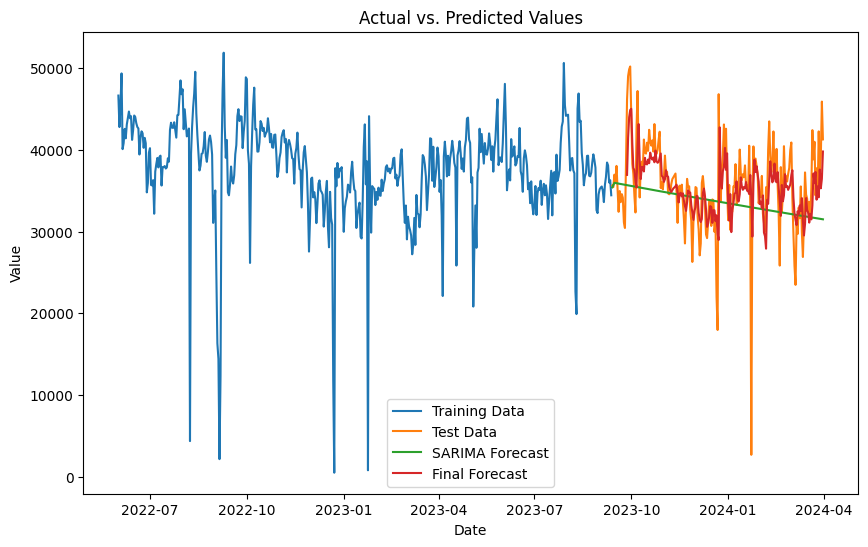

In [ ]:
# Plot actual vs. predicted values / 최종 예측 플롯
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, forecast_mean, label='SARIMA Forecast')
plt.plot(res_t3.index, res_t3['predicted_value'], label='Final Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

##RMSE

In [ ]:
print("RMSE:", rmse(jeju['총합'].tail(187), res_t3['predicted_value']))

RMSE: 4414.040344501098


#3.LSTM

In [ ]:
if isinstance(jeju_series, pd.Series):
    lstm_series = pd.DataFrame(jeju_series)

window = 13
lag = 1
lstm_series = series_to_supervised(lstm_series, window=window, lag=lag)
lstm_series

,총합(t-13),총합(t-12),총합(t-11),총합(t-10),총합(t-9),총합(t-8),총합(t-7),총합(t-6),총합(t-5),총합(t-4),총합(t-3),총합(t-2),총합(t-1),총합(t),총합(t+1)
날짜,,,,,,,,,,,,,,,
2022-06-14,46660.0,42802.0,45512.0,49374.0,40101.0,40839.0,42580.0,41424.0,43115.0,43921.0,44705.0,43888.0,44139.0,41234,42424.0
2022-06-15,42802.0,45512.0,49374.0,40101.0,40839.0,42580.0,41424.0,43115.0,43921.0,44705.0,43888.0,44139.0,41234.0,42424,44217.0
2022-06-16,45512.0,49374.0,40101.0,40839.0,42580.0,41424.0,43115.0,43921.0,44705.0,43888.0,44139.0,41234.0,42424.0,44217,44045.0
2022-06-17,49374.0,40101.0,40839.0,42580.0,41424.0,43115.0,43921.0,44705.0,43888.0,44139.0,41234.0,42424.0,44217.0,44045,43283.0
2022-06-18,40101.0,40839.0,42580.0,41424.0,43115.0,43921.0,44705.0,43888.0,44139.0,41234.0,42424.0,44217.0,44045.0,43283,42813.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26,31402.0,37249.0,34541.0,34041.0,32310.0,33644.0,31609.0,35384.0,42427.0,38842.0,41003.0,34432.0,37757.0,34694,42272.0
2024-03-27,37249.0,34541.0,34041.0,32310.0,33644.0,31609.0,35384.0,42427.0,38842.0,41003.0,34432.0,37757.0,34694.0,42272,36602.0
2024-03-28,34541.0,34041.0,32310.0,33644.0,31609.0,35384.0,42427.0,38842.0,41003.0,34432.0,37757.0,34694.0,42272.0,36602,39175.0


In [ ]:
# Y label
labels_col = '총합(t+1)'
lstm_labels = lstm_series[labels_col]

In [ ]:
lstm_series = lstm_series.drop('총합(t+1)', axis=1)

In [ ]:
lstmX_train, lstmX_test, lstmY_train, lstmY_test = train_test_split(lstm_series, lstm_labels.values, test_size=0.285, shuffle = False)
print('Train set shape', lstmX_train.shape)
print('Test set shape', lstmX_test.shape)

Train set shape (469, 14)
Test set shape (187, 14)


In [ ]:
from sklearn.preprocessing import StandardScaler

lstmY_train = lstmY_train.reshape(-1, 1)
lstmY_test = lstmY_test.reshape(-1, 1)

# standard scaler를 이용해 정규화
scaler = StandardScaler()
lstmX_train = scaler.fit_transform(lstmX_train)
lstmX_test = scaler.transform(lstmX_test)
lstmY_train = scaler.fit_transform(lstmY_train)
lstmY_test = scaler.transform(lstmY_test)

In [ ]:
lstmX_train_series = lstmX_train.reshape((lstmX_train.shape[0], lstmX_train.shape[1], 1))
lstmX_test_series = lstmX_test.reshape((lstmX_test.shape[0], lstmX_test.shape[1], 1))
print('Train set shape', lstmX_train_series.shape)
print('test set shape', lstmX_test_series.shape)

Train set shape (469, 14, 1)
test set shape (187, 14, 1)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lstm = Sequential()
lstm.add(LSTM(50, activation='relu'))
lstm.add(Dense(1))

lstm.compile(optimizer='adam', loss='mse')

In [ ]:
lstm_history = lstm.fit(lstmX_train_series, lstmY_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[ely])

Epoch 1/30
12/12 [==============================] - 2s 38ms/step - loss: 1.1132 - val_loss: 0.5152
Epoch 2/30
12/12 [==============================] - 0s 19ms/step - loss: 1.0240 - val_loss: 0.4851
Epoch 3/30
12/12 [==============================] - 0s 22ms/step - loss: 0.9501 - val_loss: 0.4638
Epoch 4/30
12/12 [==============================] - 0s 20ms/step - loss: 0.8979 - val_loss: 0.4358
Epoch 5/30
12/12 [==============================] - 0s 20ms/step - loss: 0.8701 - val_loss: 0.4270
Epoch 6/30
12/12 [==============================] - 0s 20ms/step - loss: 0.8434 - val_loss: 0.4150
Epoch 7/30
12/12 [==============================] - 0s 20ms/step - loss: 0.8367 - val_loss: 0.4091
Epoch 8/30
12/12 [==============================] - 0s 20ms/step - loss: 0.8144 - val_loss: 0.3967
Epoch 9/30
12/12 [==============================] - 0s 20ms/step - loss: 0.7991 - val_loss: 0.3900
Epoch 10/30
12/12 [==============================] - 0s 19ms/step - loss: 0.7765 - val_loss: 0.3804
Epoch 11/

In [ ]:
lyhat = lstm.predict(lstmX_test_series)
#model residual
lyhat = scaler.inverse_transform(lyhat)
df_l = pd.DataFrame(lyhat, columns=['lstm_residual'])

6/6 [==============================] - 0s 9ms/step


In [ ]:
# 시작일과 종료일 지정
start_date = '2023-09-27'
end_date = '2024-03-31'

# 날짜 범위 생성
date_range = pd.date_range(start=start_date, end=end_date)

# 날짜 범위를 데이터프레임의 인덱스로 설정
df_l.index = date_range

In [ ]:
df_l

,lstm_residual
2023-09-27,35385.652344
2023-09-28,38850.199219
2023-09-29,40919.718750
2023-09-30,42113.996094
2023-10-01,42996.480469
...,...
2024-03-27,35256.019531
2024-03-28,37864.199219
2024-03-29,36309.730469
2024-03-30,37155.031250


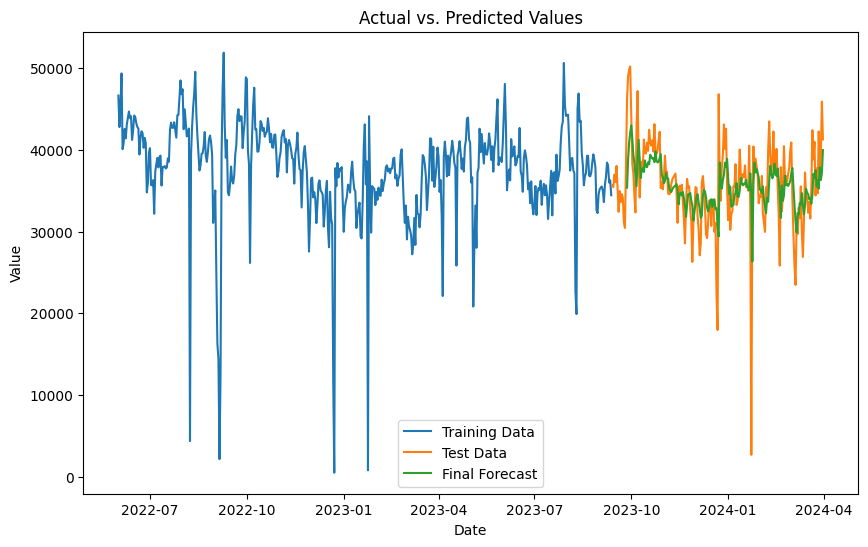

In [ ]:
# Plot actual vs. predicted values / 최종 예측 플롯
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(df_l.index, df_l['lstm_residual'], label='Final Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

##RMSE

In [ ]:
print("RMSE:", rmse(jeju['총합'].tail(187), df_l['lstm_residual']))

RMSE: 4557.1690192823935
